In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import sys  # isort:skip
from fastai.callbacks import *
from fastai.metrics import *
from fastai.vision import *
from fastai.imports import *

%config InlineBackend.figure_format = 'jpg'
import torch

from tqdm.notebook import tqdm

In [3]:
print(torch.__version__)
torch.cuda.get_device_name(0)

1.2.0


'Tesla P100-PCIE-16GB'

In [3]:
#nombre para guardar experimento
experimentName = "normal-pneumonia-covid19-resnet34-covidNET"
dataSetName = "covidNET"

#path a las imágenes
dataPath = "../data"
#Path es un método propio de FastAI
path = Path(dataPath) 
expPath = Path(os.path.abspath(Path("../experiments") / experimentName))
os.makedirs(expPath, exist_ok=True)


In [4]:
print('Carpeta models es un nombre reservado que fastAI obvia como clase')
(path/'train').ls()


Carpeta models es un nombre reservado que fastAI obvia como clase


[PosixPath('../data/train/normal'),
 PosixPath('../data/train/models'),
 PosixPath('../data/train/pneumonia'),
 PosixPath('../data/train/COVID-19')]

In [6]:
#Explorar detalles del dataset
imageNumbers = {}
for setName in ["train", "test"]:
    imageNumbers[setName] = {}
    for label in ["normal", "pneumonia" , "COVID-19"]:
        imagePath = path / f"{setName}/{label}"
        imageCount = !find $imagePath -name "*.*" | wc -l
        imageCount = int(imageCount[0].strip())
        imageNumbers[setName][label] = imageCount
print(imageNumbers)

{'train': {'normal': 7966, 'pneumonia': 5442, 'COVID-19': 98}, 'test': {'normal': 885, 'pneumonia': 594, 'COVID-19': 10}}


# Creando data sets para entrenar

- Crear sets de train y validación
- Data augmentation
- Rescalar imágenes
- Normalizar training set

## Normalización y data agumentation

Las imágenes se tienen que normalizar siguiendo las indicaciones del paper original donde se entrenó el modelo. En este caso el mismo framework se encarga de ello: se normalizan dividiendo por 255, se substrae la mediana de ImageNet y desviación estandar.
imagenet_stats: ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

Si por ejemplo usas CIFAR-10 llamarías a cifar_norm

## Detalles del train set

- bs = indica el batch size. Tenemos que ajustarlo a la capacidad de nuestra GPU. Cuanto mayor mejor entrena la red (no solo en eficiencia) porque usa más datos en cada batch
- size = ajustar al input layer de nuestra red (ver en el paper o la implementación del framework)

In [5]:
#10% para test y para validación (18% del total porque ya separamos 10% para test set). 
trainValSplit = 0.2

In [5]:
# Necesario para que los experimentos sean repetibles
np.random.seed(42)

# Data augmentation
tfms = get_transforms(
    do_flip=True,
    flip_vert=True, # Ojo!
    max_rotate=2,
    max_zoom=1.0,
    max_lighting=0.15,
    max_warp=0,
)

#size 224 porque trabajamos con transfer learning
data = ImageDataBunch.from_folder(
    path / "train",
    train=".",
    valid_pct=trainValSplit,
    resize_method=ResizeMethod.SQUISH,
    ds_tfms=tfms,
    size=224,
    num_workers=4,
    bs=64,
).normalize(imagenet_stats)

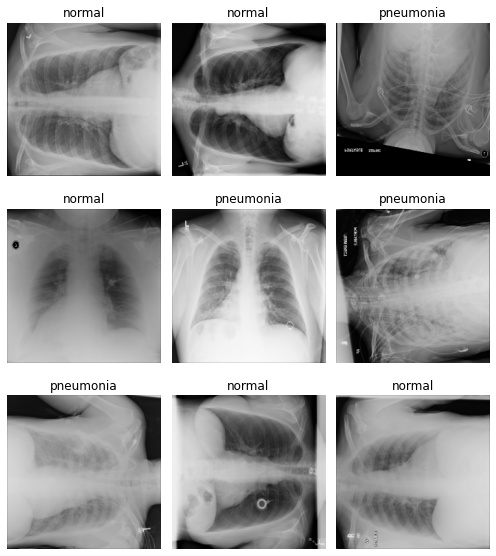

In [13]:
data.show_batch(rows=3, figsize=(7, 8))

In [6]:
np.random.seed(42)
# Data augmentation
tfms = get_transforms(
    do_flip=True,
    flip_vert=False,
    max_rotate=10,
    max_zoom=1.1,
    max_lighting=0.2,
    max_warp=0.2,
    p_affine=0.75,
    p_lighting=0.75
)
#size 224 porque trabajamos con transfer learning
#from_folder, from_csv, from_df, from_list ...
#bs= según la memoria de vuestra GPU
data = ImageDataBunch.from_folder(
    path / "train",
    train=".",
    valid_pct=trainValSplit,
    resize_method=ResizeMethod.SQUISH,
    ds_tfms=tfms,
    size=224,
    num_workers=4,
    bs=128,
).normalize(imagenet_stats)
#explain normalize

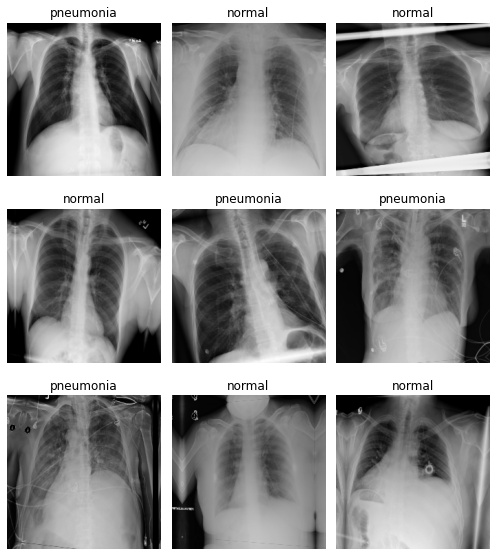

In [14]:
data.show_batch(rows=3, figsize=(7, 8))

In [9]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['COVID-19', 'normal', 'pneumonia'], 3, 10804, 2701)

## Configuración de la red

 - elegir métricas diferentes si es problema binario o multiclase.
 - usar callbacks, son funciones auxiliares que nos pueden ayudar, por ejemplo tensorboard.
 - elegir arquitectura y modelo. 
 
### Models zoo
The fastai library includes several pretrained models from torchvision, namely:

- resnet18, resnet34, resnet50, resnet101, resnet152
- squeezenet1_0, squeezenet1_1
- densenet121, densenet169, densenet201, densenet161
- vgg16_bn, vgg19_bn
- alexnet
- Darknet architecture, which is the base of Yolo v3
- Unet architecture based on a pretrained model.

https://pytorch.org/docs/stable/torchvision/models.html

https://github.com/mdgis/fastai-1/blob/master/fastai/metrics.py Más sobre las métricas



In [19]:
metrics = [
    error_rate,   # 1 - accuracy 
    accuracy,    
    Precision(),
    Recall(),         
]
#callback interesante: tensorboard
# oversampling es crear más datos de una clase
callbacks = [ShowGraph, partial(OverSamplingCallback)]

#arch = models.vgg16_bn
arch = models.resnet50
#arch = models.densenet121
learn = cnn_learner(data, arch, metrics=metrics,
                    callback_fns=callbacks)

# Hyperparámetros
Del paper sobre CovidNET

The following hyperparameters were used for training: learning rate=2e-5, number of epochs=10, batch size=8, factor=0.7, patience=5

learn = create_cnn(data, models.resnet50, metrics=[accuracy], opt_func=optim.SGD)
Edit: the default optimizer is already Adam

## Learning rate
<img src="files/impact.png">
<img src="files/loss.png">

epoch,train_loss,valid_loss,error_rate,accuracy,precision,recall,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


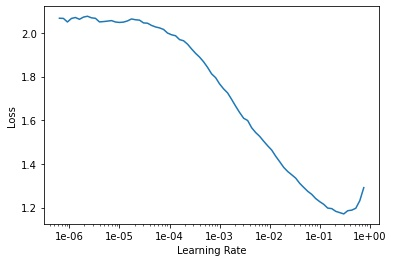

In [23]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,accuracy,precision,recall,time
0,0.307155,0.245553,0.093299,0.906701,0.775642,0.879659,08:07
1,0.179521,0.204855,0.075898,0.924102,0.874500,0.860436,07:19


/home/juanluis/anaconda3/envs/covid19/lib/python3.7/site-packages/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


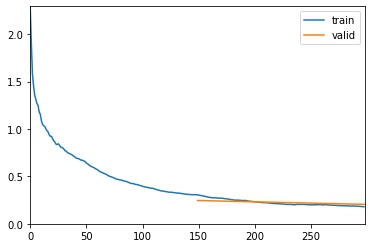

In [8]:
lr_slice = slice(1e-2)
learn.fit_one_cycle(2, max_lr=lr_slice)

epoch,train_loss,valid_loss,error_rate,accuracy,precision,recall,time
0,0.251670,0.296707,0.102555,0.897445,0.804640,0.775345,05:38
1,0.184044,0.273258,0.084043,0.915957,0.859324,0.821030,05:38
2,0.129972,0.238683,0.070715,0.929285,0.951615,0.846424,05:41
3,0.105521,0.232026,0.072195,0.927805,0.949580,0.846842,05:40
4,0.080222,0.237601,0.068123,0.931877,0.953172,0.831203,05:39
5,0.065525,0.227581,0.066642,0.933358,0.953912,0.849923,05:35


/home/juanluis/anaconda3/envs/covid19/lib/python3.7/site-packages/fastai/metrics.py:191: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


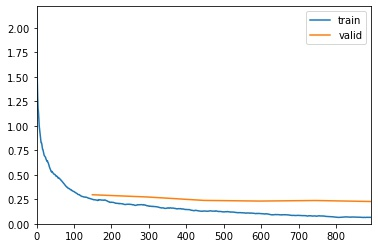

In [67]:
lr_slice = slice(1e-2)
learn.fit_one_cycle(6, max_lr=lr_slice)

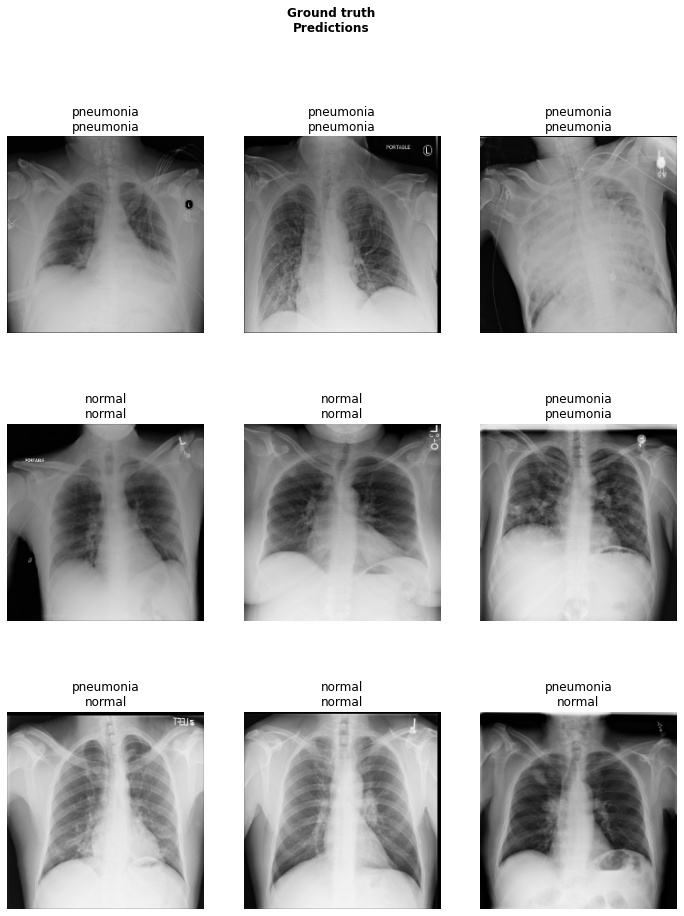

In [14]:
learn.show_results(rows=3, figsize=(12,15))

## Interpretando resultados
Matriz de confusión creada sobre las predicciones vs las etiquetas del set de validación. TP y TN = aciertos un FP predijimos, por ejemplo, que tenía neumonía pero no la tiene y FN predijimos que estaba normal pero el paciente tenía neumonía
<img src="files/3.png">

Curva precision/recall importante en medicina para disminuir los falsos negativos
<img src="files/prec-recall.png">

(2.5, -0.5)

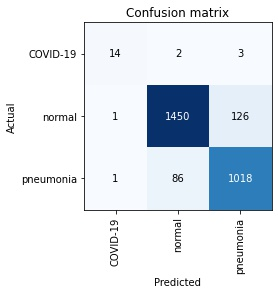

In [15]:
#Resnet50
interp = ClassificationInterpretation.from_learner(learn)
cm_fig = interp.plot_confusion_matrix(return_fig=True)
ax = cm_fig.gca()
ax.set_ylim(interp.data.c - 0.5, -0.5)

(2.5, -0.5)

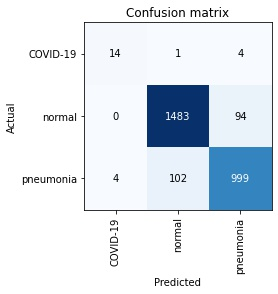

In [9]:
#densenet
interp = ClassificationInterpretation.from_learner(learn)
cm_fig = interp.plot_confusion_matrix(return_fig=True)
ax = cm_fig.gca()
ax.set_ylim(interp.data.c - 0.5, -0.5)

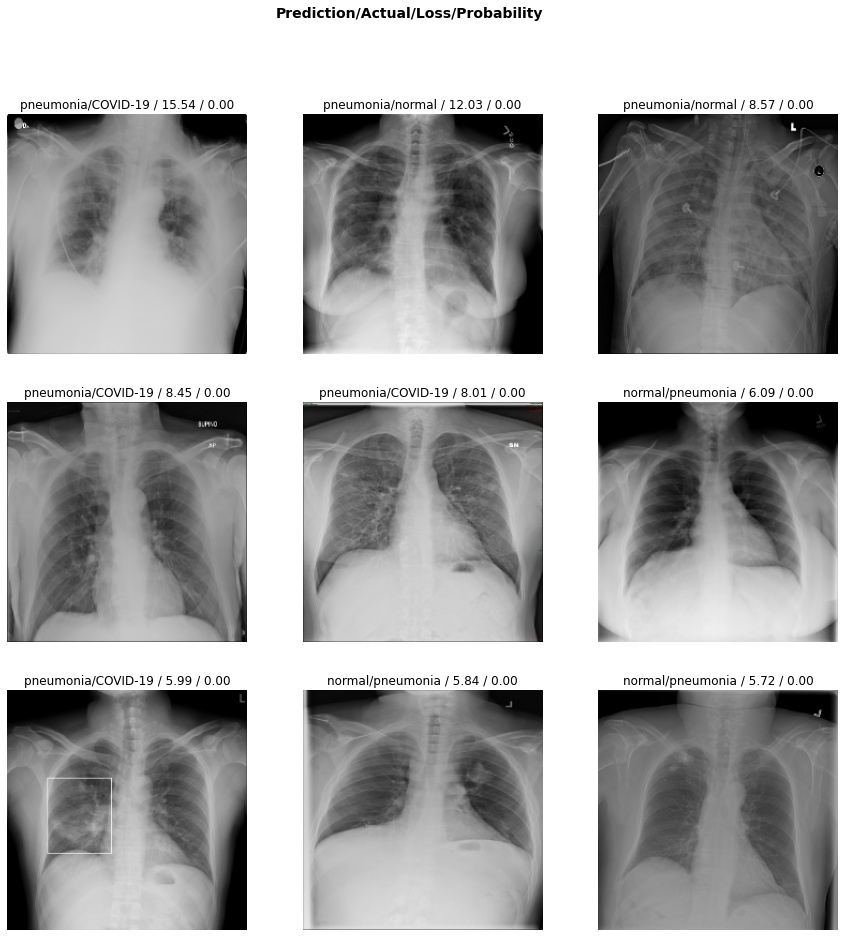

In [57]:
interp.plot_top_losses(9, figsize=(15,15))
#prediction/actual/loss/probability.

<img src="files/7bcb680b5c63719a54558c6cc4dd51db5366e590_fastai-image-classification-10.png">


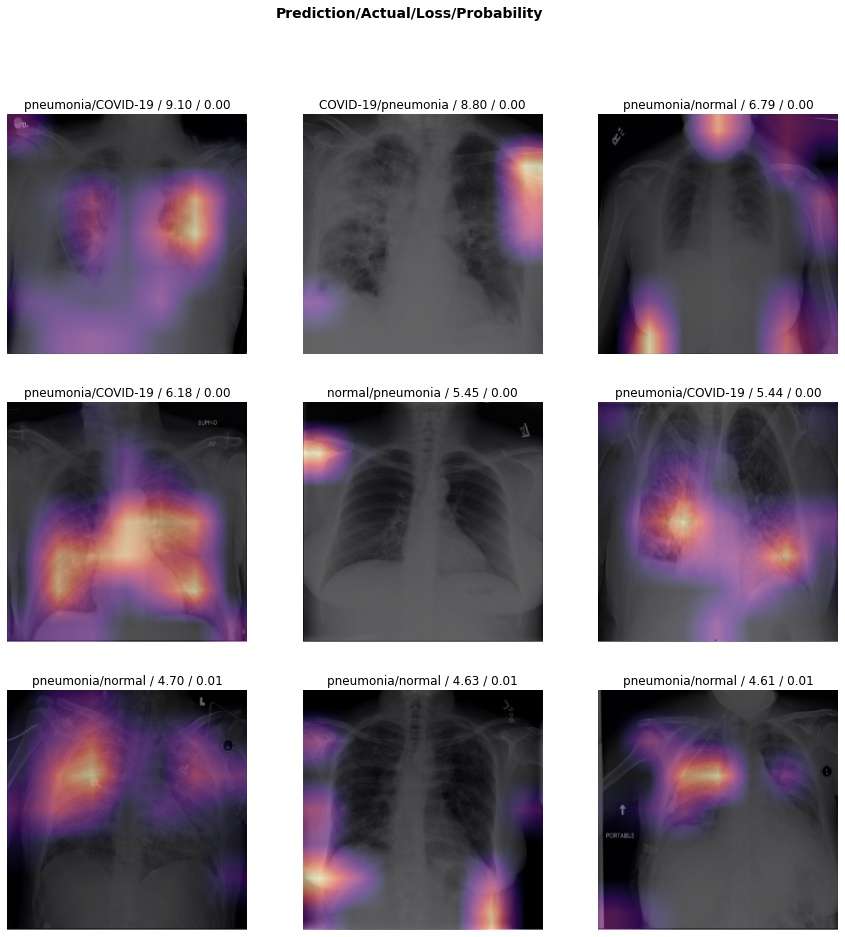

In [8]:
interp.plot_top_losses(9,figsize=(15,15),heatmap=True,heatmap_thresh=16)

<img src="files/c41bb3bec3019ba95e28cb97a9c0d5c0189a03ef.jpeg">


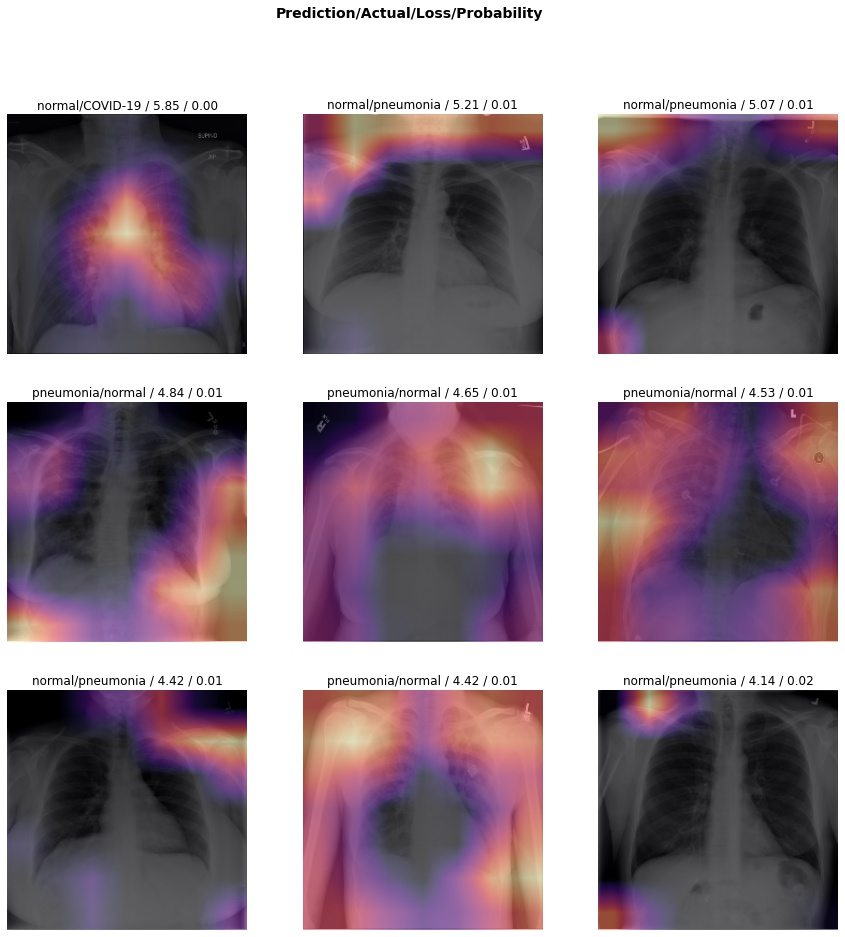

In [10]:
interp.plot_top_losses(9,figsize=(15,15),heatmap=True,heatmap_thresh=16)

In [10]:
#Fine tuning que yo conozco como transfer learning :)
learn.unfreeze()

epoch,train_loss,valid_loss,error_rate,accuracy,precision,recall,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


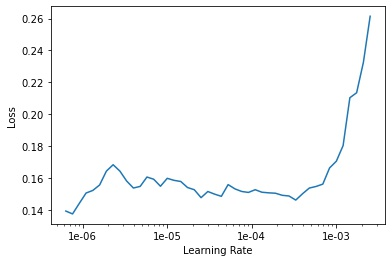

In [11]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,error_rate,accuracy,precision,recall,time
0,0.144028,0.182214,0.064791,0.935209,0.929078,0.834821,07:25
1,0.119589,0.171688,0.056275,0.943725,0.936492,0.838689,07:26
2,0.125829,0.172125,0.057756,0.942244,0.932224,0.821685,07:27
3,0.116776,0.173022,0.058497,0.941503,0.931415,0.821623,07:28


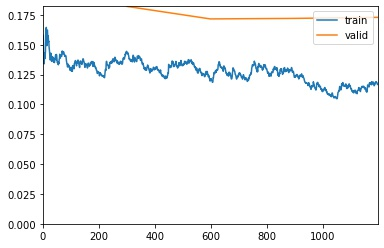

In [12]:
lr_slice = slice(1e-6, 1e-4)
learn.fit_one_cycle(4, max_lr=lr_slice)

(2.5, -0.5)

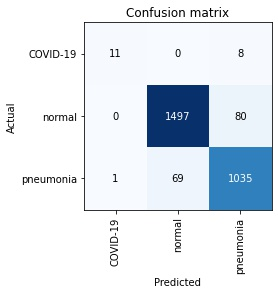

In [13]:
interp = ClassificationInterpretation.from_learner(learn)
cm_fig = interp.plot_confusion_matrix(return_fig=True)
ax = cm_fig.gca()
ax.set_ylim(interp.data.c - 0.5, -0.5)

## Guardar experimentos
Se trata de ir experimentando y buscar la mejor combinación para resolver nuestro problema. Podemos guardar experimentos sin necesidad de exportar modelos

experiments/normal-pneumonia-covid19-resnet34-covidNET-entropy

Cuando cargamos un experimento (model entrenado) tenemos que cargar la config de la arquitectura (learn = cnn_learner(data, arch, metrics=metrics,callback_fns=callbacks))

In [11]:
learn.save(expPath / "resnet50_2_epochs")

In [20]:
learn.load(expPath / "resnet50_2_epochs")
#si da error raro es porque no has cargado la config de la arquitectura

Learner(data=ImageDataBunch;

Train: LabelList (10804 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
normal,normal,normal,normal,normal
Path: ../data/train;

Valid: LabelList (2701 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
pneumonia,pneumonia,pneumonia,normal,normal
Path: ../data/train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [16]:
#exportar un modelo para producción
learn.export(expPath / "vgg.pkl")

## Testear nuestro modelo


normal tensor(1) tensor([0.0044, 0.7276, 0.2680])
tensor(0.7276)


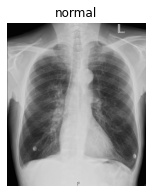

In [21]:
#!wget https://i.pinimg.com/originals/75/cd/27/75cd27da32f411118fa2cfaeb58167a6.png
testImagePath = "75cd27da32f411118fa2cfaeb58167a6.png"    
testImg = open_image(testImagePath)
cat, tensor, probs = learn.predict(testImg)
testImg.show(y=learn.predict(testImg)[0])
confidence = max(probs)
percent = float(confidence)
print(cat, tensor, probs)
print(confidence)

normal tensor(1) tensor([6.4041e-04, 8.0302e-01, 1.9634e-01])
tensor(0.8030)


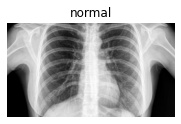

In [22]:
#!wget https://www.healthimaging.com/sites/default/files/styles/media_image_mobile/public/assets/articles/4996132.jpg
testImagePath = "4996132.jpg"    
testImg = open_image(testImagePath)
cat, tensor, probs = learn.predict(testImg)
testImg.show(y=learn.predict(testImg)[0])
confidence = max(probs)
percent = float(confidence)
print(cat, tensor, probs)
print(confidence)

In [23]:
# benchmark test images
def getFilename(sliceName: str) -> str:
    parts = sliceName.split("-+-")
    if len(parts) == 1:
        parts = sliceName.split("!")
    return f"{parts[0]}.jpg"
classNames = ['COVID-19', 'normal', 'pneumonia']
extensions = ['.jpeg','.png','jpg']
# test images
testResults = {}
correctedTest = f"{path}/test/"
fileMap = {}
entropyResults = {}

for subdir in classNames:
    testResults[subdir] = {}
    subdirPath = "{}/{}".format(correctedTest, subdir)
    subdirFiles = list(os.scandir(subdirPath))
    wrongCount = 0
    correctCount = 0
    for files in tqdm(subdirFiles):
        #if files.name not in extensions :
        #    print(f"Skipping {files.name}")

        testImagePath = "{}/{}".format(subdirPath, str(files.name))        
        testImg = open_image(testImagePath)
        pred_class, pred_idx, outputs = learn.predict(testImg)
        confidence = outputs[pred_idx]        
        #print(subdir,pred_class)
        resultObj = {}
        resultObj["imagePath"] = testImagePath
        resultObj["prediction"] = str(pred_class)
        resultObj["label"] = subdir
        print
        if str(pred_class) == subdir:
            correctCount += 1
            resultObj["correct"] = True
        else:
            wrongCount += 1
            resultObj["correct"] = False
        
        entropyResults[str(files.name)] = resultObj
        # store outcome in map for easy lookup
        fileMap[testImagePath] = str(pred_class) == subdir

    testResults[subdir]["correct"] = correctCount
    testResults[subdir]["incorrect"] = wrongCount
    print(f"{subdir} Files: {len(subdirFiles)} predicted {(correctCount)}")

print("Finished Testing")


COVID-19 Files: 10 predicted 5



normal Files: 885 predicted 839



pneumonia Files: 594 predicted 548
Finished Testing


### Resnet50 8 epochs
COVID-19 Files: 10 predicted 4

normal Files: 885 predicted 825

pneumonia Files: 594 predicted 561

Finished Testing

### Resnet50 2 epochs
COVID-19 Files: 10 predicted 6

normal Files: 885 predicted 832

pneumonia Files: 594 predicted 554

Finished Testing


### Densenet121

COVID-19 Files: 10 predicted 7

normal Files: 885 predicted 829

pneumonia Files: 594 predicted 560

Finished Testing

### VGG16

COVID-19 Files: 10 predicted 3

normal Files: 885 predicted 833

pneumonia Files: 594 predicted 549

Finished Testing

--2020-04-17 17:34:02--  https://upload.wikimedia.org/wikipedia/en/7/76/Darth_Vader.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20799 (20K) [image/jpeg]
Saving to: '/tmp/Darth_Vader.jpg'

/tmp/Darth_Vader.jp 100%[===================>]  20.31K  --.-KB/s    in 0.01s   

2020-04-17 17:34:02 (1.61 MB/s) - '/tmp/Darth_Vader.jpg' saved [20799/20799]

COVID-19 tensor([9.9966e-01, 1.1174e-04, 2.2441e-04])


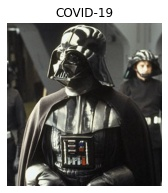

In [24]:
!wget https://upload.wikimedia.org/wikipedia/en/7/76/Darth_Vader.jpg -O /tmp/Darth_Vader.jpg
testImagePath3 = "/tmp/Darth_Vader.jpg"
testImg3 = open_image(testImagePath3)
cat, tensor, probs = learn.predict(testImg3)
print(cat,probs)
testImg3.show(y=learn.predict(testImg3)[0])


## Próximos pasos

Os recomiendo este artículo que justamente hace lo mismo que nosotros pero es mucho más completo porque no hace transfer learning.

https://towardsdatascience.com/does-imagenet-pretraining-work-for-chest-radiography-images-covid-19-2e2d9f5f0875


- Recoger más ejemplos de COVID-19
- Mejoraría el trabajo en el balanceo de clases
- Buscaría modelos prentrenados en radiografías o Grayscale ImageNet
